# Baseline Model

## 資料前處理
文字部份取`review`欄位。
`rating`原範圍1-10, 定義1-4分為負評(標記：-1), 5-7分為中性評論(標記：0), 8-10分為好評(標記：1)。新增`polarity`欄位紀錄好評、中性評論及負評標記。
建立 drugSet 紀錄所有`drugName`及`condition`出現過的藥名與治療目的，文字全部轉為小寫，作為額外的stopwords。
`review`部份全部過濾標點符號、停用字，並轉為小寫，但保留數字。

## Feature & Target
利用 sklearn 的 CountVectorizer 建立詞頻紀錄，作為輸入的 feature，feature 大小為原始資料詞庫大小：63011。target 則是`polarity`欄位。

## Model
- Logistic Regression

training accuracy:
0.8425451186320886

testing accuracy:
0.7738719636945282

- SVC

training accuracy:
0.604456375506054

testing accuracy:
0.6018115537700406

- MultinomialNB

training accuracy:
0.7533246123610483

testing accuracy:
0.7220734293047651


In [1]:
# Read data

import pandas as pd
import numpy as np

train_data_path = './drugsComments/train.tsv'
test_data_path = './drugsComments/test.tsv'

train_df = pd.read_csv(train_data_path, sep='\t')
test_df = pd.read_csv(test_data_path, sep='\t')

print(train_df.shape)
print(train_df.head())

(161297, 7)
   Unnamed: 0                  drugName                     condition  \
0      206461                 Valsartan  Left Ventricular Dysfunction   
1       95260                Guanfacine                          ADHD   
2       92703                    Lybrel                 Birth Control   
3      138000                Ortho Evra                 Birth Control   
4       35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  
0       May 20, 2012           27  
1     April 27, 2010          192  
2  December 14, 2009           17  
3   November 3, 2015

Drop the columns `Unnamed` and `date`, which are unnecessary. Then, there are 5 columns left:

In [2]:
# Drop unnecessary columns: Unnamed & date

train_df.drop(columns=['Unnamed: 0', 'date'], inplace=True)
test_df.drop(columns=['Unnamed: 0', 'date'], inplace=True)

print(train_df.shape)
print(train_df.head())

(161297, 5)
                   drugName                     condition  \
0                 Valsartan  Left Ventricular Dysfunction   
1                Guanfacine                          ADHD   
2                    Lybrel                 Birth Control   
3                Ortho Evra                 Birth Control   
4  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  usefulCount  
0  "It has no side effect, I take it in combinati...     9.0           27  
1  "My son is halfway through his fourth week of ...     8.0          192  
2  "I used to take another oral contraceptive, wh...     5.0           17  
3  "This is my first time using any form of birth...     8.0           10  
4  "Suboxone has completely turned my life around...     9.0           37  


In [3]:
# Keep a set which includes all the names of drugs and conditions occurred in the dataset.

import re

drugNameSet_train = set(train_df['drugName'])
conditionNameSet_train = set(train_df['condition'])
drugNameSet_test = set(test_df['drugName'])
conditionNameSet_test = set(test_df['condition'])

oldDrugSet = drugNameSet_train | conditionNameSet_train | drugNameSet_test | conditionNameSet_test

REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")

drugSet = set()

for drug in oldDrugSet:
    drugStr = str(drug).lower()
    if not("helpful." in drugStr):
        drugStr = REPLACE_NO_SPACE.sub("", drugStr)
        drugSet.add(drugStr)

drugSet.remove('nan')


# Print `drugSet`

print('size of drugSet:\n')
print(len(drugSet))
print('\nFirst 20 drug names:\n')
showNum = 20
countNum = 0
for drug in drugSet:
    print(drug)
    countNum += 1
    if(countNum == showNum):
        break

size of drugSet:

4507

First 20 drug names:

renvela
avalide
eletriptan
mulation phenylephrine
uterine bleeding
phenergan
dramamine
lybrel
urispas
blephamide
pitavastatin
prednisolone
gold sodium thiomalate
casodex
goserelin
std prophylaxis
endometriosis
l-methylfolate calcium
schizoaffective disorde
triple paste


In [4]:
# Define `polarity`

train_df['polarity'] = pd.cut(train_df['rating'], bins=[-1, 4, 7, 10], labels=[-1, 0, 1])
test_df['polarity'] = pd.cut(test_df['rating'], bins=[-1, 4, 7, 10], labels=[-1, 0, 1])

print(train_df[['rating', 'polarity']].head(30))

    rating polarity
0      9.0        1
1      8.0        1
2      5.0        0
3      8.0        1
4      9.0        1
5      2.0       -1
6      1.0       -1
7     10.0        1
8      1.0       -1
9      8.0        1
10     9.0        1
11    10.0        1
12     4.0       -1
13     4.0       -1
14     3.0       -1
15     9.0        1
16     9.0        1
17     9.0        1
18    10.0        1
19    10.0        1
20     8.0        1
21    10.0        1
22     9.0        1
23    10.0        1
24     1.0       -1
25     7.0        0
26    10.0        1
27    10.0        1
28     6.0        0
29     8.0        1


In [5]:
# Text cleaning

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm

tqdm.pandas()

REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

stopWords = set(stopwords.words('english'))

def filter_stopwords(sentence):
    sentence = sentence.replace("&#039;", "'")
    sentence = sentence.lower()
    
    sentence = REPLACE_NO_SPACE.sub("", sentence)
    sentence = REPLACE_WITH_SPACE.sub(" ", sentence)
    
    words = word_tokenize(sentence)
    wordsFiltered = []
    for w in words:
        if (w not in stopWords) and (w not in drugSet):
            wordsFiltered.append(w)
    joinStr = " "
    return joinStr.join(wordsFiltered)

print('before cleaning:\n')
print(train_df['review'].head().values)

train_df['review'] = train_df['review'].progress_apply(filter_stopwords)
test_df['review'] = test_df['review'].progress_apply(filter_stopwords)

print('\nafter cleaning:\n')
print(train_df['review'].head().values)

  0%|          | 112/161297 [00:00<02:24, 1115.81it/s]

before cleaning:

['"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"'
 '"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective."'
 '"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it

100%|██████████| 53766/53766 [00:40<00:00, 1317.05it/s]


after cleaning:

['side effect take combination 5 mg fish oil'
 'son halfway fourth week became concerned began last week started taking highest dose two days could hardly get bed cranky slept nearly 8 hours drive home school vacation unusual called doctor monday morning said stick days see school getting morning last two days problem free much agreeable ever less emotional good thing less cranky remembering things overall behavior better tried many different medications far effective'
 'used take another oral contraceptive 21 pill cycle happy light periods max 5 days side effects contained hormone gestodene available us switched ingredients similar pills ended started immediately first day period instructions said period lasted two weeks taking second pack two weeks third pack things got even worse third period lasted two weeks end third week still daily brown discharge positive side didnt side effects idea period free tempting alas'
 'first time using form birth control im glad went

In [6]:
# Word counts

from sklearn.feature_extraction.text import CountVectorizer
import datetime

print(datetime.datetime.now())
print('\n')

vectorizer = CountVectorizer()

vectorizer.fit(train_df['review'])
data_train_x_count = vectorizer.transform(train_df['review'])
data_test_x_count = vectorizer.transform(test_df['review'])

print('training data shape:')
print(data_train_x_count.shape)

print('\nthe first input data looks like:')
print(type(data_train_x_count))
print(data_train_x_count[0])

print('\n')
print(datetime.datetime.now())

2019-05-16 05:55:08.648779


training data shape:
(161297, 63011)

the first input data looks like:
<class 'scipy.sparse.csr.csr_matrix'>
  (0, 14294)	1
  (0, 20360)	1
  (0, 23476)	1
  (0, 35235)	1
  (0, 39022)	1
  (0, 51443)	1
  (0, 55349)	1


2019-05-16 05:55:33.752868


In [7]:
# Show first 100 words in the corpus

words = vectorizer.get_feature_names()
print('corpus size:')
print(len(words))
print('\n')

showNum = 100
countNum = 0
for word in words:
    print(word)
    countNum += 1
    if(countNum == showNum):
        break

corpus size:
63011


00
000
0000
00007
0001
0002
0003
0009
000vl
001
0010782485900484
0015
001mg
001mgs
002
0020
0025
0025mg
0025now
002s
003
0030
00375
003mg
004
005
0050
00550mcgfor
005mg
006
0075
008
01
010
0100
012
0125
0125mg
0133
0137mcg
0145
015
0150mcg
016
017
01mg
02
0200
02092016
0210
0216
02252016
0230am
0235
024
025
025mcgs
025mg
025mgs
025ml
027
0270
02g
02mg
03
032
0325
034
035
035mg
0375
0375mg
03mg
03milligrams
04
0400
042
0433am
045
0450
045mg
04mg
05
050
0500
050mcgs
050mg
0530
054
055lbs
059
05g
05l
05lpm
05mg
05mg1hr
05mgs
05ml
05s
05x2


In [14]:
# Logistic Regression

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

print(datetime.datetime.now())
print('\n')

print('--- Logistic Regression ---\n')

lr_model = LogisticRegression(max_iter=100)
lr_model.fit(data_train_x_count, train_df['polarity'])

lr_predict_train_y = lr_model.predict(data_train_x_count)
print('training accuracy:')
print(accuracy_score(train_df['polarity'], lr_predict_train_y))

lr_predict_test_y = lr_model.predict(data_test_x_count)
print('\ntesting accuracy:')
print(accuracy_score(test_df['polarity'], lr_predict_test_y))

print('\nprecision, recall, fbeta-score:')
print(precision_recall_fscore_support(test_df['polarity'], lr_predict_test_y, average='weighted'))
print('\nconfusion matrix:')
cm_lr = confusion_matrix(test_df['polarity'], lr_predict_test_y)
print(cm_lr)

print('\n')
print(datetime.datetime.now())

2019-05-16 06:01:54.771748


--- Logistic Regression ---

training accuracy:
0.8425451186320886

testing accuracy:
0.7738719636945282

precision, recall, fbeta-score:
(0.7548065573192635, 0.7738719636945282, 0.7541219653378419, None)

confusion matrix:
[[ 9782   700  3015]
 [ 1765  2107  4048]
 [ 1730   900 29719]]


2019-05-16 06:03:57.780045


In [15]:
# SVC

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.svm import SVC

print(datetime.datetime.now())
print('\n')

print('--- SVC ---\n')

# Normalize data
scaler = StandardScaler(with_mean=False)
scaler.fit(data_train_x_count)

train_normalize = scaler.transform(data_train_x_count)
test_normalize = scaler.transform(data_test_x_count)

# fit & predict
svc_model = SVC(kernel='linear', max_iter=50)
svc_model.fit(train_normalize, train_df['polarity'])

svc_predict_train_y = svc_model.predict(train_normalize)
print('training accuracy:')
print(accuracy_score(train_df['polarity'], svc_predict_train_y))

svc_predict_test_y = svc_model.predict(test_normalize)
print('\ntesting accuracy:')
print(accuracy_score(test_df['polarity'], svc_predict_test_y))

print('\nprecision, recall, fbeta-score:')
print(precision_recall_fscore_support(test_df['polarity'], svc_predict_test_y, average='weighted'))
print('\nconfusion matrix:')
cm_svc = confusion_matrix(test_df['polarity'], svc_predict_test_y)
print(cm_svc)

print('\n')
print(datetime.datetime.now())

2019-05-16 06:03:57.795054


--- SVC ---



/home/iris/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/iris/.local/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy:
0.604456375506054

testing accuracy:
0.6018115537700406

precision, recall, fbeta-score:
(0.5542583762648987, 0.6018115537700406, 0.4537656615829548, None)

confusion matrix:
[[   34     6 13457]
 [    5    14  7901]
 [   29    11 32309]]


2019-05-16 06:04:54.270782


In [16]:
# Naive Bayes

from sklearn.naive_bayes import MultinomialNB

print(datetime.datetime.now())
print('\n')

print('--- MultinomialNB ---\n')

nb_model = MultinomialNB()
nb_model.fit(data_train_x_count, train_df['polarity'])

nb_predict_train_y = nb_model.predict(data_train_x_count)
print('training accuracy:')
print(accuracy_score(train_df['polarity'], nb_predict_train_y))

nb_predict_test_y = nb_model.predict(data_test_x_count)
print('\ntesting accuracy:')
print(accuracy_score(test_df['polarity'], nb_predict_test_y))

print('\nprecision, recall, fbeta-score:')
print(precision_recall_fscore_support(test_df['polarity'], nb_predict_test_y, average='weighted'))
print('\nconfusion matrix:')
cm_nb = confusion_matrix(test_df['polarity'], nb_predict_test_y)
print(cm_nb)

print('\n')
print(datetime.datetime.now())

2019-05-16 06:04:54.284317


--- MultinomialNB ---

training accuracy:
0.7533246123610483

testing accuracy:
0.7220734293047651

precision, recall, fbeta-score:
(0.705381173108705, 0.7220734293047651, 0.7113673323233134, None)

confusion matrix:
[[ 8918  1003  3576]
 [ 1922  2329  3669]
 [ 2589  2184 27576]]


2019-05-16 06:04:54.614612


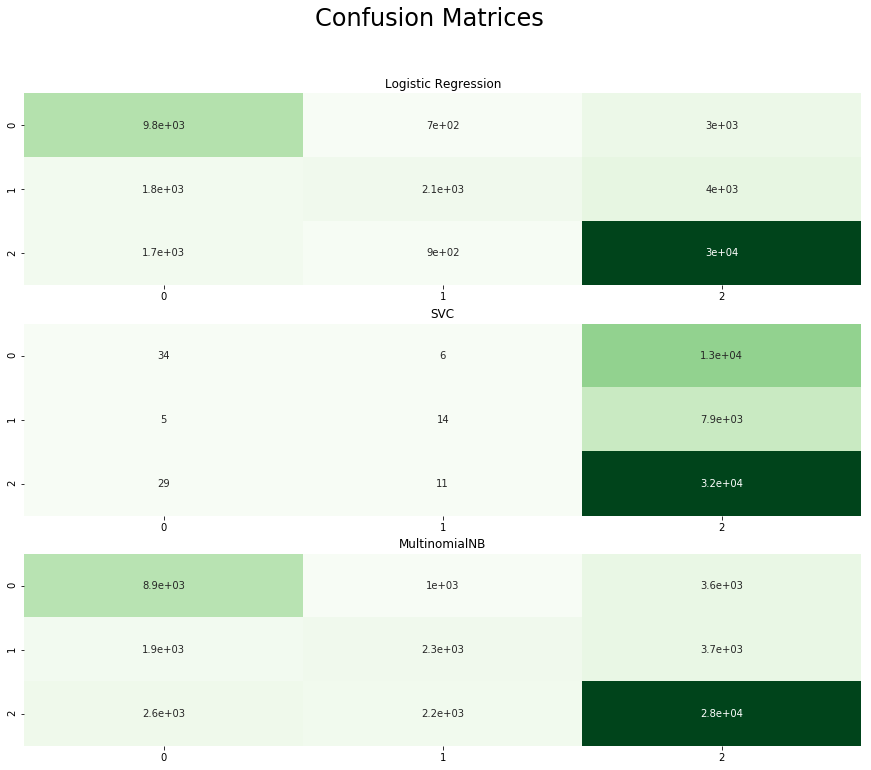

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,12))
plt.suptitle("Confusion Matrices",fontsize=24)

plt.subplot(3,1,1)
plt.title("Logistic Regression")
sns.heatmap(cm_lr, annot = True, cmap="Greens",cbar=False)

plt.subplot(3,1,2)
plt.title("SVC")
sns.heatmap(cm_svc, annot = True, cmap="Greens",cbar=False)

plt.subplot(3,1,3)
plt.title("MultinomialNB")
sns.heatmap(cm_nb, annot = True, cmap="Greens",cbar=False)